**This notebook is about**:
* Trying out the UK Open Data API
* Requesting data on corona virus from [GOV.UK Coronavirus(COVID-19) Open Data API](https://coronavirus.data.gov.uk/details/developers-guide/main-api)
* Doing some pretty quick and dirty data exploration
* Getting some simple statistics
* Visualising the results

In [1]:
from typing import Iterable, Dict, Union, List
import json
from requests import get
from http import HTTPStatus

In [2]:
StructureType = Dict[str, Union[dict, str]]
FiltersType = Iterable[str]
APIResponseType = Union[List[StructureType], str]

In [3]:
def get_paginated_dataset(filters: FiltersType, structure: StructureType, as_csv: bool = False) -> APIResponseType:
    '''
    Extracts paginated data by requesting all of the pages
    and combining the results.

    Parameters
    ----------
    filters: Iterable[str]
        API filters. See the API documentations for additional
        information.

    structure: Dict[str, Union[dict, str]]
        Structure parameter. See the API documentations for
        additional information.
        as_csv: bool
        Return the data as CSV. [default: ``False``]

    Returns
    -------
    Union[List[StructureType], str]
        Comprehensive list of dictionaries containing all the data for
        the given ``filters`` and ``structure``.
    '''
    endpoint = 'https://api.coronavirus.data.gov.uk/v1/data'
    
    api_params = {'filters': str.join(';', filters),
                  'structure': json.dumps(structure, separators = (',', ':')),
                  'format': 'json' if not as_csv else 'csv'
                 }
    data = list()
    page_number = 1
    while True:
        # add page number to query params
        api_params['page'] = page_number
        response = get(endpoint, params = api_params, timeout = 10)
        if response.status_code >= HTTPStatus.BAD_REQUEST:
            raise RuntimeError(f'Request failed: {response.text}')
        elif response.status_code == HTTPStatus.NO_CONTENT:
            break
        if as_csv:
            csv_content = response.content.decode()
            # Removing CSV header (column names) where page number is greater than 1
            if page_number > 1:
                data_lines = csv_content.split('\n')[1:]
                csv_content = str.join('\n', data_lines)
            data.append(csv_content.strip())
            page_number += 1
            continue
        current_data = response.json()
        page_data: List[StructureType] = current_data['data']
        data.extend(page_data)
        # The "next" attribute in "pagination" will be `None` when we reach the end
        if not current_data['pagination']['next']:
            break
        page_number += 1
    if not as_csv:
        return data
    # concatenating CSV pages
    return str.join('\n', data)

In [4]:
query_filters = [f'areaType=region']
query_structure = {"date": "date",
                   "name": "areaName",
                   "code": "areaCode",
                   "daily": "newCasesBySpecimenDate",
                   "cumulative": "cumCasesBySpecimenDate"
                  }

#### Get the data in json

In [5]:
json_data = get_paginated_dataset(query_filters, query_structure)

In [6]:
print(f'Length: {len(json_data)}')
print(f'Data (first 3 items):\n{json_data[:3]}')
#print('---' * 10)

Length: 9175
Data (first 3 items):
[{'date': '2022-11-23', 'name': 'North West', 'code': 'E12000002', 'daily': 236, 'cumulative': 2771727}, {'date': '2022-11-22', 'name': 'North West', 'code': 'E12000002', 'daily': 375, 'cumulative': 2771491}, {'date': '2022-11-21', 'name': 'North West', 'code': 'E12000002', 'daily': 413, 'cumulative': 2771116}]


#### Get the data as `csv`
Some people prefer to work with **`csv`** data...

In [7]:
csv_data = get_paginated_dataset(query_filters, query_structure, as_csv = True)

In [8]:
csv_lines = csv_data.split("\n")
print(f'Length: {len(csv_lines)}')
print(f'Data (first 3 lines):\n{csv_lines[:3]}')

Length: 9176
Data (first 3 lines):
['date,name,code,daily,cumulative', '2022-11-23,North West,E12000002,236,2771727', '2022-11-22,North West,E12000002,375,2771491']


**Save the data to disk**

In [9]:
with open('./data/data.json', 'wt') as f:
    json.dump(json_data, f)

**Load and analyse data**

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')

**Read the data from disk and create a DataFrame**

In [11]:
df = pd.read_json('./data/data.json').set_index('date')
print(df.shape)
df.head()

(9175, 4)


,name,code,daily,cumulative
date,,,,
2022-11-23,North West,E12000002,236,2771727
2022-11-22,North West,E12000002,375,2771491
2022-11-21,North West,E12000002,413,2771116
2022-11-20,North West,E12000002,293,2770703
2022-11-19,North West,E12000002,261,2770410


In [12]:
print(type(df.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


**Create columns for year, month and day**

In [13]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df.head()

,name,code,daily,cumulative,year,month,day
date,,,,,,,
2022-11-23,North West,E12000002,236,2771727,2022,11,23
2022-11-22,North West,E12000002,375,2771491,2022,11,22
2022-11-21,North West,E12000002,413,2771116,2022,11,21
2022-11-20,North West,E12000002,293,2770703,2022,11,20
2022-11-19,North West,E12000002,261,2770410,2022,11,19


In [14]:
df.rename(columns = {'name': 'region'}, inplace = True)       # rename the column 'name' to 'region'
df.head()

,region,code,daily,cumulative,year,month,day
date,,,,,,,
2022-11-23,North West,E12000002,236,2771727,2022,11,23
2022-11-22,North West,E12000002,375,2771491,2022,11,22
2022-11-21,North West,E12000002,413,2771116,2022,11,21
2022-11-20,North West,E12000002,293,2770703,2022,11,20
2022-11-19,North West,E12000002,261,2770410,2022,11,19


In [15]:
print(df.code.nunique())
print(df.region.nunique())

9
9


## Regional Yearly Tally

In [16]:
regional_yearly = df.groupby(['region', 'year'])['daily'].sum().unstack()
regional_yearly.head()

year,2020,2021,2022
region,,,
East Midlands,196447,824615,705920
East of England,216743,1021067,985001
London,422967,1532910,1142330
North East,130128,458160,433064
North West,388459,1355557,1027711


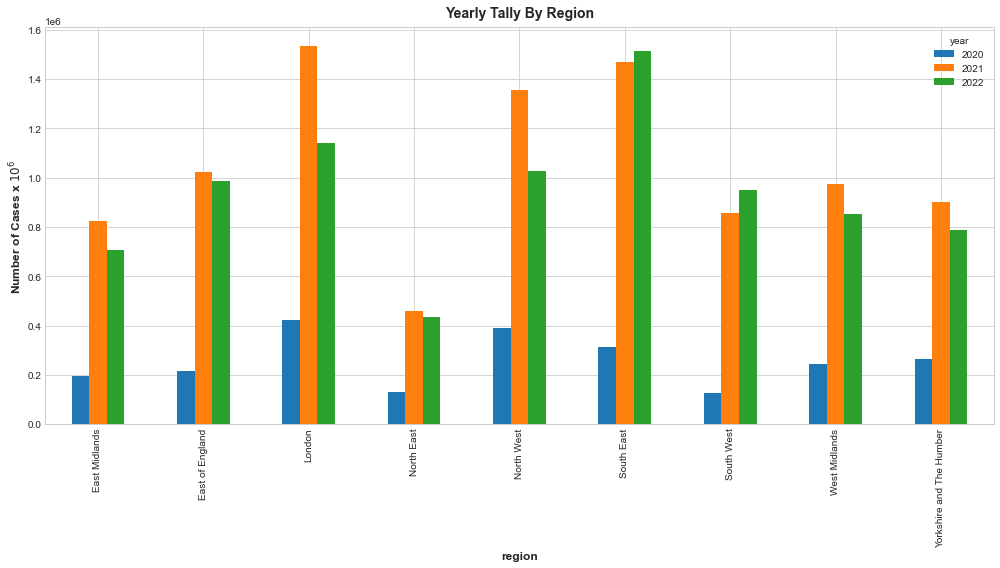

In [17]:
regional_yearly.plot(kind = 'bar', figsize = (14, 8))
plt.title('Yearly Tally By Region')
plt.ylabel('Number of Cases x $10^6$')
plt.show()

The chart shows that: 
* **All regions were at peak period in 2021**
* The **least** affected region is **North East**

### Nation-wide monthly Tally

In [18]:
regional_monthly = df.groupby(['year', 'month'])['daily'].sum().unstack()
regional_monthly.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
regional_monthly.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
year,,,,,,,,,,,,
2020,1.0,54.0,31527.0,112508.0,66904.0,25202.0,19212.0,30065.0,127351.0,485065.0,531892.0,871685.0
2021,1101256.0,301063.0,141039.0,62831.0,64405.0,302942.0,950642.0,796025.0,776225.0,1067888.0,1024847.0,2805081.0
2022,3194632.0,1097116.0,1775001.0,649761.0,198253.0,382519.0,522774.0,148410.0,147509.0,210998.0,65832.0,NaN


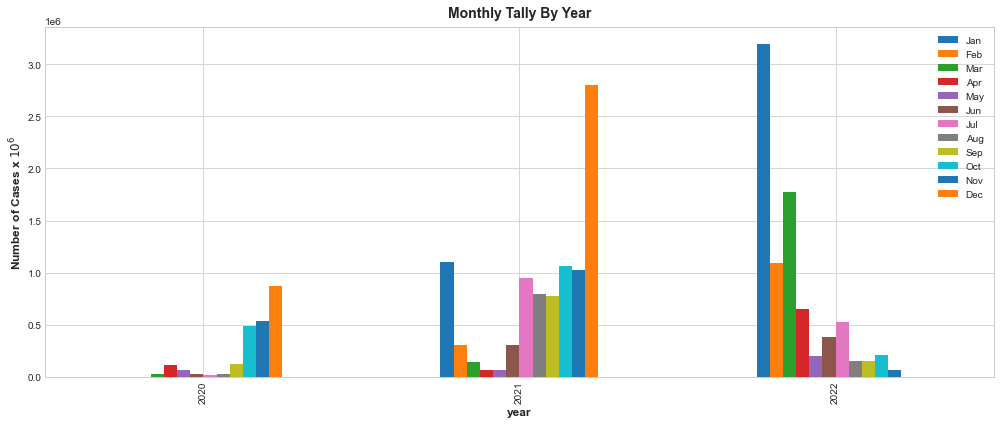

In [19]:
regional_monthly.plot(kind = 'bar', figsize = (14, 6))
plt.title('Monthly Tally By Year')
plt.ylabel('Number of Cases x $10^6$')
plt.show()

* The disproportionate high cases in **December 2021 - January 2022** is due to the outbreak of the **omicron** variant. 
* There was a **general decline** in the number of cases in **Feb 2022** followed by a sudden rise in **March 2022**.
* There is a significant drop in the number of infection since **`August 31, 2022`** with a drastic drop in **`November 2022`**.

#### Daily Variation in the number of cases

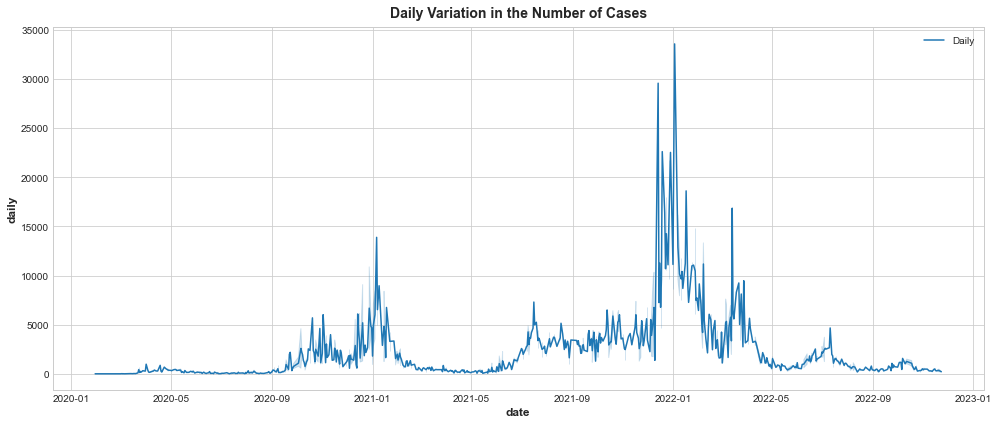

In [22]:
plt.figure(figsize = (14, 6))
sns.lineplot(data = df.daily.sample(1000), label = 'Daily')
plt.title('Daily Variation in the Number of Cases')
plt.show()

**The daily statistics agrees with the monthly tally above with spikes in the periods `December - January` which saw the outbreak of `Delta`and `Omicron`variants respectively**. 

#### The infection rate has dropped significantly as of `November 30, 2022`

### Aggregate Tally by Region

In [23]:
regional_agg = df.groupby(['region'])['daily'].sum()
regional_agg.head()

region
East Midlands      1726982
East of England    2222811
London             3098207
North East         1021352
North West         2771727
Name: daily, dtype: int64

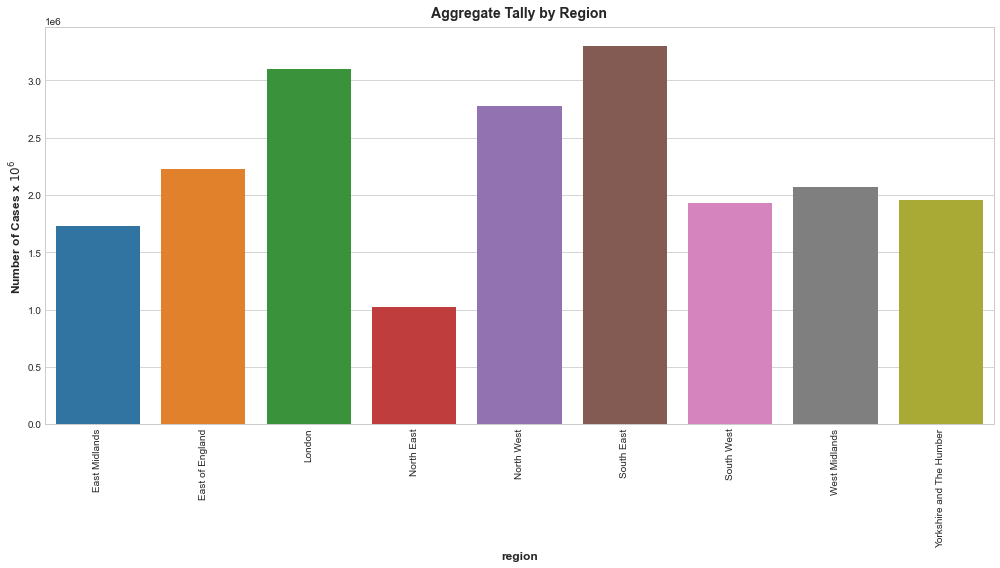

In [24]:
plt.figure(figsize = (14, 8))
sns.barplot(x = regional_agg.index, y = regional_agg.values)
plt.title('Aggregate Tally by Region')
plt.ylabel('Number of Cases x $10^6$')
plt.xticks(rotation = 90)
plt.show()

**North East, the least hit region, is certain doing something different which is worth emulating...!!**

### Pie Chart representing same information as above

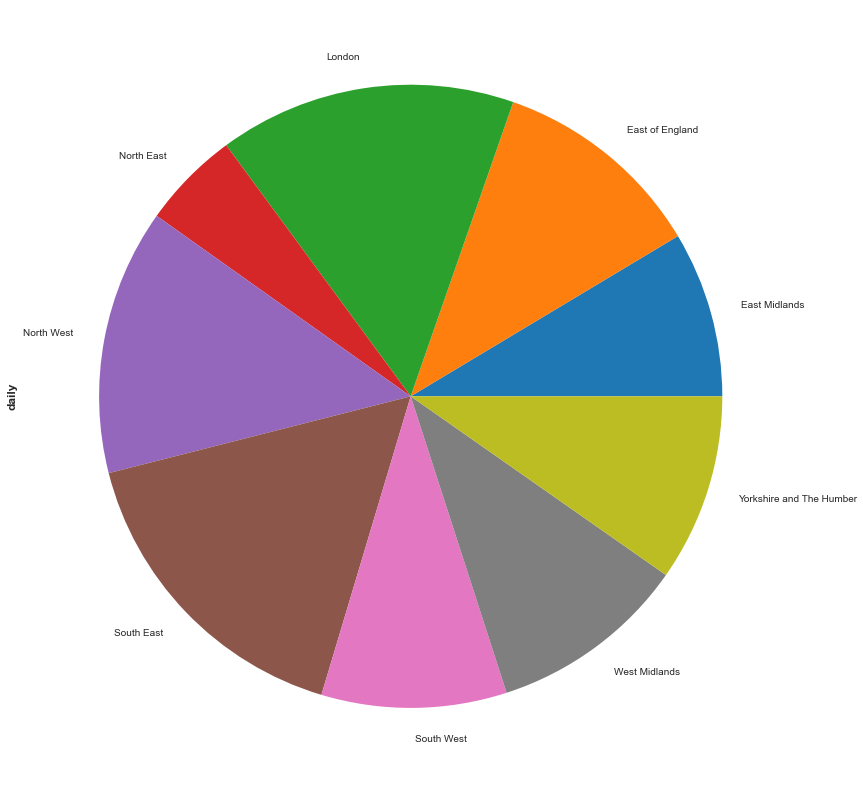

In [25]:
regional_agg.plot(kind = 'pie', subplots = True, figsize = (12, 12))
plt.show()

**`South East`, `London` and `North West` are highly hit with `South East` being the most hit region as of `November 30, 2022`**. 